<a href="https://colab.research.google.com/github/Dev123dahiya/Foreign-seek-deepfake-audio-detection/blob/main/audio_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install librosa soundfile flask pyngrok tensorflow scikit-learn matplotlib seaborn tqdm joblib requests pillow opencv-python pandas numpy pyttsx3

import os
import shutil

directories = [
    'dataset/real',
    'dataset/fake',
    'models',
    'uploads',
    'templates',
    'assets'
]

for directory in directories:
    os.makedirs(directory, exist_ok=True)

print("✓ Project structure created!")
print("✓ All packages installed!")


✓ Project structure created!
✓ All packages installed!


In [1]:
audio_preprocessing_code = '''
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

class AudioPreprocessor:
    def __init__(self, sample_rate=22050, n_mels=128, duration=3):
        """Initialize AudioPreprocessor with default parameters"""
        self.sample_rate = sample_rate
        self.n_mels = n_mels
        self.duration = duration
        self.max_len = sample_rate * duration

    def load_audio(self, file_path):
        """Load audio file and normalize"""
        try:
            audio, sr = librosa.load(file_path, sr=self.sample_rate, duration=self.duration)

            # Pad or trim to fixed length
            if len(audio) < self.max_len:
                audio = np.pad(audio, (0, self.max_len - len(audio)), mode='constant')
            else:
                audio = audio[:self.max_len]

            return audio
        except Exception as e:
            print(f"Error loading {file_path}: {str(e)}")
            return None

    def audio_to_melspectrogram(self, audio):
        """Convert audio to mel spectrogram"""
        mel_spec = librosa.feature.melspectrogram(
            y=audio,
            sr=self.sample_rate,
            n_mels=self.n_mels
        )

        # Convert to dB scale
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        return mel_spec_db

    def extract_features(self, audio):
        """Extract additional audio features"""
        features = {}

        # MFCC features
        mfcc = librosa.feature.mfcc(y=audio, sr=self.sample_rate, n_mfcc=13)
        features['mfcc_mean'] = np.mean(mfcc, axis=1)

        # Spectral features
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=self.sample_rate)[0]
        features['spectral_centroid_mean'] = np.mean(spectral_centroid)

        spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=self.sample_rate)[0]
        features['spectral_rolloff_mean'] = np.mean(spectral_rolloff)

        # Zero crossing rate
        zcr = librosa.feature.zero_crossing_rate(audio)[0]
        features['zcr_mean'] = np.mean(zcr)

        return features

    def process_dataset(self, dataset_path):
        """Process entire dataset and create spectrograms"""
        spectrograms = []
        labels = []

        print(f"Processing dataset from: {dataset_path}")

        # Get all audio files and their labels
        audio_files = []
        for root, dirs, files in os.walk(dataset_path):
            for file in files:
                if file.endswith(('.wav', '.mp3', '.flac', '.m4a', '.ogg')):
                    full_path = os.path.join(root, file)
                    label = os.path.basename(root)
                    audio_files.append((full_path, label))

        print(f"Found {len(audio_files)} audio files")

        for i, (file_path, label) in enumerate(audio_files):
            if i % 10 == 0:
                print(f"Processing file {i+1}/{len(audio_files)}")

            # Load audio
            audio = self.load_audio(file_path)
            if audio is None:
                continue

            # Generate mel spectrogram
            mel_spec = self.audio_to_melspectrogram(audio)
            spectrograms.append(mel_spec)
            labels.append(label)

        # Convert to numpy arrays
        spectrograms = np.array(spectrograms)
        labels = np.array(labels)

        print(f"Processed {len(spectrograms)} files successfully")
        return spectrograms, labels
'''

with open('audio_preprocessing.py', 'w') as f:
    f.write(audio_preprocessing_code)

print("✓ audio_preprocessing.py created!")


✓ audio_preprocessing.py created!


In [2]:
# Create cnn_model.py
cnn_model_code = '''
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import joblib
import os

class DeepfakeDetectionCNN:
    def __init__(self, input_shape=(128, 130, 1)):
        """Initialize CNN model for deepfake detection"""
        self.input_shape = input_shape
        self.model = None
        self.history = None
        self.label_encoder = LabelEncoder()

    def build_model(self):
        """Build CNN model architecture"""
        model = models.Sequential([
            # Input layer
            layers.Input(shape=self.input_shape),

            # First Conv Block
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            # Second Conv Block
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            # Third Conv Block
            layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.GlobalAveragePooling2D(),

            # Dense layers
            layers.Dense(512, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),

            # Output layer
            layers.Dense(1, activation='sigmoid')
        ])

        self.model = model
        return model

    def compile_model(self, learning_rate=0.001):
        """Compile the model"""
        optimizer = optimizers.Adam(learning_rate=learning_rate)

        self.model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        print("Model compiled successfully!")
        print(f"Total parameters: {self.model.count_params():,}")

    def prepare_data(self, spectrograms, labels, test_size=0.2, val_size=0.1):
        """Prepare data for training"""
        # Encode labels
        y_encoded = self.label_encoder.fit_transform(labels)

        # Reshape spectrograms if needed
        if len(spectrograms.shape) == 3:
            spectrograms = spectrograms[..., np.newaxis]

        # Split data
        X_temp, X_test, y_temp, y_test = train_test_split(
            spectrograms, y_encoded, test_size=test_size, random_state=42, stratify=y_encoded
        )

        val_size_adjusted = val_size / (1 - test_size)
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_size_adjusted, random_state=42, stratify=y_temp
        )

        print(f"Training set: {X_train.shape[0]} samples")
        print(f"Validation set: {X_val.shape[0]} samples")
        print(f"Test set: {X_test.shape[0]} samples")

        return X_train, X_val, X_test, y_train, y_val, y_test

    def train_model(self, X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
        """Train the CNN model"""
        # Setup callbacks
        callbacks_list = [
            callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True,
                verbose=1
            ),
            callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-7,
                verbose=1
            )
        ]

        # Train model
        print("Starting training...")
        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks_list,
            verbose=1
        )

        print("Training completed!")
        return self.history

    def evaluate_model(self, X_test, y_test):
        """Evaluate model performance"""
        # Make predictions
        y_pred_proba = self.model.predict(X_test)
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()

        # Calculate metrics
        test_loss, test_accuracy = self.model.evaluate(X_test, y_test, verbose=0)

        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Test Loss: {test_loss:.4f}")

        # Classification report
        class_names = self.label_encoder.classes_
        report = classification_report(y_test, y_pred, target_names=class_names)
        print("\\nClassification Report:")
        print(report)

        return test_accuracy, test_loss

    def save_model(self, model_path):
        """Save trained model"""
        os.makedirs(os.path.dirname(model_path), exist_ok=True)
        self.model.save(model_path)

        # Save label encoder
        encoder_path = model_path.replace('.h5', '_encoder.pkl')
        joblib.dump(self.label_encoder, encoder_path)

        print(f"Model saved to {model_path}")

    def load_model(self, model_path):
        """Load trained model"""
        self.model = tf.keras.models.load_model(model_path)

        # Load label encoder
        encoder_path = model_path.replace('.h5', '_encoder.pkl')
        if os.path.exists(encoder_path):
            self.label_encoder = joblib.load(encoder_path)
            print(f"Model and encoder loaded from {model_path}")

    def predict_single(self, spectrogram):
        """Make prediction on a single spectrogram"""
        if len(spectrogram.shape) == 2:
            spectrogram = spectrogram[np.newaxis, ..., np.newaxis]
        elif len(spectrogram.shape) == 3:
            spectrogram = spectrogram[np.newaxis, ...]

        prediction = self.model.predict(spectrogram, verbose=0)[0][0]

        if len(self.label_encoder.classes_) >= 2:
            if prediction > 0.5:
                predicted_class = self.label_encoder.classes_[1]
                confidence = float(prediction)
            else:
                predicted_class = self.label_encoder.classes_[0]
                confidence = float(1 - prediction)
        else:
            if prediction > 0.5:
                predicted_class = "fake"
                confidence = float(prediction)
            else:
                predicted_class = "real"
                confidence = float(1 - prediction)

        return predicted_class, confidence
'''

with open('cnn_model.py', 'w') as f:
    f.write(cnn_model_code)

print("✓ cnn_model.py created!")


✓ cnn_model.py created!


In [3]:
train_code = '''
import os
import numpy as np
from audio_preprocessing import AudioPreprocessor
from cnn_model import DeepfakeDetectionCNN

def train_deepfake_model(dataset_path="dataset/", epochs=50, batch_size=32):
    """Main training function"""
    print("=" * 60)
    print("  DEEPFAKE AUDIO DETECTION - TRAINING")
    print("=" * 60)

    # Initialize preprocessor
    preprocessor = AudioPreprocessor(sample_rate=22050, duration=3)

    # Process dataset
    print("Processing dataset...")
    spectrograms, labels = preprocessor.process_dataset(dataset_path)

    if len(spectrograms) == 0:
        print("ERROR: No audio files found!")
        print("Please upload audio files to dataset/real/ and dataset/fake/")
        return None, None

    print(f"Successfully processed {len(spectrograms)} audio files")

    # Check label distribution
    unique_labels, counts = np.unique(labels, return_counts=True)
    print("\\nDataset distribution:")
    for label, count in zip(unique_labels, counts):
        print(f"  {label}: {count} files")

    # Initialize CNN model
    print("\\nInitializing CNN model...")
    cnn = DeepfakeDetectionCNN(input_shape=(128, spectrograms.shape[2], 1))

    # Build model
    model = cnn.build_model()
    cnn.compile_model(learning_rate=0.001)

    # Prepare data
    print("\\nPreparing training data...")
    X_train, X_val, X_test, y_train, y_val, y_test = cnn.prepare_data(spectrograms, labels)

    # Train model
    print(f"\\nStarting training for {epochs} epochs...")
    history = cnn.train_model(
        X_train, y_train, X_val, y_val,
        epochs=epochs,
        batch_size=batch_size
    )

    # Evaluate model
    print("\\nEvaluating model...")
    test_accuracy, test_loss = cnn.evaluate_model(X_test, y_test)

    # Save model
    model_path = 'models/deepfake_detection_model.h5'
    cnn.save_model(model_path)

    print("\\n" + "=" * 60)
    print("  TRAINING COMPLETED!")
    print("=" * 60)
    print(f"Final test accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"Model saved to: {model_path}")

    return cnn, history

if __name__ == "__main__":
    model, history = train_deepfake_model()
'''

with open('train_model.py', 'w') as f:
    f.write(train_code)

print("✓ train_model.py created!")


✓ train_model.py created!


In [4]:
flask_code = '''
from flask import Flask, render_template, request, jsonify
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')
import io
import base64
import uuid
from datetime import datetime
from audio_preprocessing import AudioPreprocessor
from cnn_model import DeepfakeDetectionCNN

app = Flask(__name__)
app.config['UPLOAD_FOLDER'] = 'uploads'
app.config['MAX_CONTENT_LENGTH'] = 16 * 1024 * 1024  # 16MB

ALLOWED_EXTENSIONS = {'wav', 'mp3', 'flac', 'm4a', 'ogg'}

# Global variables
model = None
preprocessor = None

def allowed_file(filename):
    return '.' in filename and filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS

def initialize_components():
    global model, preprocessor

    print("Initializing components...")
    preprocessor = AudioPreprocessor(sample_rate=22050, duration=3)
    model = DeepfakeDetectionCNN(input_shape=(128, 130, 1))

    model_path = 'models/deepfake_detection_model.h5'
    if os.path.exists(model_path):
        model.load_model(model_path)
        print("✓ Trained model loaded!")
    else:
        print("⚠ No trained model found - using demo mode")
        model.build_model()
        model.compile_model()

def create_spectrogram_plot(spectrogram, title="Mel Spectrogram"):
    plt.figure(figsize=(12, 6))
    plt.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.xlabel('Time Frames')
    plt.ylabel('Mel Frequency Bins')
    plt.tight_layout()

    img_buffer = io.BytesIO()
    plt.savefig(img_buffer, format='png', dpi=100, bbox_inches='tight')
    img_buffer.seek(0)
    img_string = base64.b64encode(img_buffer.read()).decode()
    plt.close()

    return img_string

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/upload', methods=['POST'])
def upload_file():
    try:
        if 'file' not in request.files:
            return jsonify({'error': 'No file uploaded'}), 400

        file = request.files['file']
        if not allowed_file(file.filename):
            return jsonify({'error': 'Invalid file type'}), 400

        # Save file temporarily
        filename = file.filename
        filepath = os.path.join(app.config['UPLOAD_FOLDER'], f"{uuid.uuid4()}_{filename}")
        os.makedirs(app.config['UPLOAD_FOLDER'], exist_ok=True)
        file.save(filepath)

        # Process audio
        audio = preprocessor.load_audio(filepath)
        if audio is None:
            os.remove(filepath)
            return jsonify({'error': 'Failed to process audio'}), 400

        mel_spec = preprocessor.audio_to_melspectrogram(audio)

        # Make prediction
        if model.model is not None and os.path.exists('models/deepfake_detection_model.h5'):
            prediction, confidence = model.predict_single(mel_spec)
        else:
            # Demo prediction
            prediction = "fake" if np.random.random() > 0.5 else "real"
            confidence = 0.70 + np.random.random() * 0.25

        # Create visualization
        spectrogram_img = create_spectrogram_plot(mel_spec, f"Mel Spectrogram - {filename}")

        # Extract features
        features = preprocessor.extract_features(audio)

        # Clean up
        os.remove(filepath)

        return jsonify({
            'success': True,
            'filename': filename,
            'prediction': prediction,
            'confidence': confidence,
            'confidence_percent': confidence * 100,
            'spectrogram_image': spectrogram_img,
            'features': {
                'spectral_centroid_mean': float(features['spectral_centroid_mean']),
                'spectral_rolloff_mean': float(features['spectral_rolloff_mean']),
                'zcr_mean': float(features['zcr_mean']),
            },
            'analysis_time': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        })

    except Exception as e:
        return jsonify({'error': f'Server error: {str(e)}'}), 500

if __name__ == '__main__':
    initialize_components()
    app.run(host='0.0.0.0', port=5000, debug=True)
'''

with open('flask_app.py', 'w') as f:
    f.write(flask_code)

print("✓ flask_app.py created!")


✓ flask_app.py created!


In [ ]:
html_code = '''<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Deepfake Audio Detection</title>
    <link href="https://cdn.jsdelivr.net/npm/bootstrap@5.1.3/dist/css/bootstrap.min.css" rel="stylesheet">
    <style>
        body {
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            min-height: 100vh;
        }
        .main-container {
            background: rgba(255, 255, 255, 0.95);
            border-radius: 20px;
            padding: 40px;
            margin: 40px auto;
            max-width: 1200px;
        }
        .upload-area {
            border: 3px dashed #667eea;
            border-radius: 15px;
            padding: 60px 20px;
            text-align: center;
            margin-bottom: 30px;
            cursor: pointer;
        }
        .upload-area:hover {
            border-color: #764ba2;
            background: rgba(118, 75, 162, 0.1);
        }
        .results-container {
            display: none;
            margin-top: 40px;
        }
        .result-card {
            background: white;
            border-radius: 15px;
            box-shadow: 0 10px 30px rgba(0, 0, 0, 0.1);
            margin-bottom: 25px;
            padding: 30px;
        }
        .prediction-badge {
            font-size: 1.5rem;
            padding: 15px 30px;
            border-radius: 50px;
            font-weight: 700;
            margin: 20px 0;
        }
        .real { background: #28a745; color: white; }
        .fake { background: #dc3545; color: white; }
        .spectrogram-image {
            max-width: 100%;
            border-radius: 10px;
        }
        .loading-spinner {
            display: none;
            text-align: center;
            margin: 30px 0;
        }
    </style>
</head>
<body>
    <div class="container">
        <div class="main-container">
            <div class="text-center mb-4">
                <h1>🎵 Deepfake Audio Detection</h1>
                <p class="lead">Upload an audio file to detect if it's real or synthetic</p>
            </div>

            <div class="upload-area" id="uploadArea">
                <div style="font-size: 4rem; color: #667eea; margin-bottom: 20px;">📁</div>
                <div style="font-size: 1.2rem; margin-bottom: 15px;">
                    <strong>Drop your audio file here or click to browse</strong>
                </div>
                <p class="text-muted">Supported: WAV, MP3, FLAC, M4A, OGG (Max: 16MB)</p>
                <input type="file" id="fileInput" style="display: none;" accept=".wav,.mp3,.flac,.m4a,.ogg">
                <button class="btn btn-primary" onclick="document.getElementById('fileInput').click()">
                    Choose File
                </button>
            </div>

            <div class="loading-spinner" id="loadingSpinner">
                <div class="spinner-border text-primary" style="width: 4rem; height: 4rem;"></div>
                <p class="mt-3">Analyzing audio file...</p>
            </div>

            <div class="results-container" id="resultsContainer">
                <div class="result-card">
                    <h3>Analysis Results</h3>
                    <p id="fileName"></p>

                    <div class="row">
                        <div class="col-md-6 text-center">
                            <h5>Prediction</h5>
                            <div id="predictionBadge" class="prediction-badge"></div>
                        </div>
                        <div class="col-md-6 text-center">
                            <h5>Confidence</h5>
                            <div id="confidenceDisplay" style="font-size: 2rem; font-weight: bold;"></div>
                        </div>
                    </div>

                    <p><strong>Analysis Time:</strong> <span id="analysisTime"></span></p>
                </div>

                <div class="result-card">
                    <h4>Mel Spectrogram</h4>
                    <div class="text-center">
                        <img id="spectrogramImage" class="spectrogram-image" alt="Spectrogram">
                    </div>
                </div>

                <div class="result-card">
                    <h4>Technical Features</h4>
                    <div id="technicalFeatures"></div>
                </div>
            </div>
        </div>
    </div>

    <script>
        const uploadArea = document.getElementById('uploadArea');
        const fileInput = document.getElementById('fileInput');
        const loadingSpinner = document.getElementById('loadingSpinner');
        const resultsContainer = document.getElementById('resultsContainer');

        uploadArea.addEventListener('click', () => fileInput.click());
        fileInput.addEventListener('change', (e) => {
            if (e.target.files.length > 0) {
                handleFileUpload(e.target.files[0]);
            }
        });

        function handleFileUpload(file) {
            const allowedExtensions = ['.wav', '.mp3', '.flac', '.m4a', '.ogg'];
            const fileExtension = '.' + file.name.split('.').pop().toLowerCase();

            if (!allowedExtensions.includes(fileExtension)) {
                alert('Invalid file type. Please upload WAV, MP3, FLAC, M4A, or OGG files.');
                return;
            }

            if (file.size > 16 * 1024 * 1024) {
                alert('File too large. Maximum size is 16MB.');
                return;
            }

            loadingSpinner.style.display = 'block';
            resultsContainer.style.display = 'none';

            const formData = new FormData();
            formData.append('file', file);

            fetch('/upload', {
                method: 'POST',
                body: formData
            })
            .then(response => response.json())
            .then(data => {
                loadingSpinner.style.display = 'none';
                if (data.success) {
                    displayResults(data);
                } else {
                    alert('Error: ' + (data.error || 'Upload failed'));
                }
            })
            .catch(error => {
                loadingSpinner.style.display = 'none';
                alert('Network error: ' + error.message);
            });
        }

        function displayResults(data) {
            document.getElementById('fileName').innerHTML = `<strong>File:</strong> ${data.filename}`;

            const predictionBadge = document.getElementById('predictionBadge');
            predictionBadge.textContent = data.prediction.toUpperCase();
            predictionBadge.className = `prediction-badge ${data.prediction}`;

            document.getElementById('confidenceDisplay').textContent = `${data.confidence_percent.toFixed(1)}%`;
            document.getElementById('analysisTime').textContent = data.analysis_time;
            document.getElementById('spectrogramImage').src = `data:image/png;base64,${data.spectrogram_image}`;

            const features = data.features;
            document.getElementById('technicalFeatures').innerHTML = `
                <div class="row">
                    <div class="col-md-4">
                        <strong>Spectral Centroid:</strong> ${features.spectral_centroid_mean.toFixed(2)} Hz
                    </div>
                    <div class="col-md-4">
                        <strong>Spectral Rolloff:</strong> ${features.spectral_rolloff_mean.toFixed(2)} Hz
                    </div>
                    <div class="col-md-4">
                        <strong>Zero Crossing Rate:</strong> ${features.zcr_mean.toFixed(4)}
                    </div>
                </div>
            `;

            resultsContainer.style.display = 'block';
        }
    </script>
</body>
</html>'''

with open('templates/index.html', 'w') as f:
    f.write(html_code)

print("✓ templates/index.html created!")
print("\n" + "="*50)
print(" ALL PROJECT FILES CREATED SUCCESSFULLY!")
print("="*50)


✓ templates/index.html created!

 ALL PROJECT FILES CREATED SUCCESSFULLY!


In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

# First, let's check if Drive is properly mounted
if os.path.exists('/content/drive'):
    print("✅ Google Drive is mounted")
else:
    print("❌ Google Drive is NOT mounted")
    print("Please run: from google.colab import drive; drive.mount('/content/drive')")

# Check what's in your Drive root
print("\n📁 Contents of MyDrive root:")
mydrive_path = '/content/drive/MyDrive'
if os.path.exists(mydrive_path):
    items = os.listdir(mydrive_path)
    for item in sorted(items):
        item_path = os.path.join(mydrive_path, item)
        if os.path.isdir(item_path):
            print(f"📂 {item}/")
        else:
            print(f"📄 {item}")
else:
    print("❌ MyDrive path not found!")


✅ Google Drive is mounted

📁 Contents of MyDrive root:
📄 AI Generated Fake Audio as a New Threat to Information Security:  Legal and Forensic Aspects.gdoc
📄 AltaCV_Template__1_ (1).pdf
📄 BIOMED XPERT Equipment Dashboard.html
📂 Colab Notebooks/
📄 Dev Dahiya.pdf
📄 Fake speech detection using VGGish with attention block.gdoc
📄 Forensic Audio Inspection and Content Verification Platform.gslides
📄 Literature Review of Recent Research in Forensic Audio Inspection and Content Verification.gdoc
📄 Math Test Paper.pdf
📄 Subjective_Questions.pdf
📂 deepfake_dataset/
📄 index (4).html
📄 resume cyber.pdf
📄 resume software (1).pdf
📄 resume software final.pdf
📄 resume software.pdf


In [ ]:
# Let's search for folders with names containing 'deepfake', 'audio', 'archive', etc.
def search_for_folders(root_path, search_terms):
    """Search for folders containing specific terms"""
    found_folders = []

    try:
        for root, dirs, files in os.walk(root_path):
            # Limit search depth to avoid taking too long
            depth = root.replace(root_path, '').count(os.sep)
            if depth > 3:  # Only search 3 levels deep
                continue

            for dir_name in dirs:
                for term in search_terms:
                    if term.lower() in dir_name.lower():
                        full_path = os.path.join(root, dir_name)
                        found_folders.append(full_path)
                        break
    except PermissionError:
        pass

    return found_folders

# Search for your dataset folder
search_terms = ['deepfake', 'audio', 'archive', 'for-', 'dataset']
print("🔍 Searching for your dataset folders...")
print("This may take a minute...")

found_folders = search_for_folders('/content/drive/MyDrive', search_terms)

print(f"\n📁 Found {len(found_folders)} potential dataset folders:")
for folder in found_folders[:10]:  # Show first 10 results
    print(f"  {folder}")

    # Check if this folder contains the subfolders we're looking for
    target_subfolders = ['for-rerec', 'for-original', 'for-norm', 'for-2sec']
    subfolder_count = 0

    for subfolder in target_subfolders:
        subfolder_path = os.path.join(folder, subfolder)
        if os.path.exists(subfolder_path):
            subfolder_count += 1

    if subfolder_count > 0:
        print(f"    ✅ Contains {subfolder_count}/4 target subfolders")

        # This might be our dataset! Let's check what's inside
        print(f"    📋 Contents of {folder}:")
        try:
            contents = os.listdir(folder)
            for item in sorted(contents):
                item_path = os.path.join(folder, item)
                if os.path.isdir(item_path):
                    print(f"      📂 {item}/")
        except:
            print("      ❌ Cannot read contents")
    else:
        print(f"    ℹ️  No target subfolders found")


🔍 Searching for your dataset folders...
This may take a minute...

📁 Found 10 potential dataset folders:
  /content/drive/MyDrive/deepfake_dataset
    ℹ️  No target subfolders found
  /content/drive/MyDrive/deepfake_dataset/archive
    ✅ Contains 4/4 target subfolders
    📋 Contents of /content/drive/MyDrive/deepfake_dataset/archive:
      📂 for-2sec/
      📂 for-norm/
      📂 for-original/
      📂 for-rerec/
  /content/drive/MyDrive/deepfake_dataset/archive/for-original
    ✅ Contains 1/4 target subfolders
    📋 Contents of /content/drive/MyDrive/deepfake_dataset/archive/for-original:
      📂 for-original/
  /content/drive/MyDrive/deepfake_dataset/archive/for-rerec
    ℹ️  No target subfolders found
  /content/drive/MyDrive/deepfake_dataset/archive/for-2sec
    ℹ️  No target subfolders found
  /content/drive/MyDrive/deepfake_dataset/archive/for-norm
    ✅ Contains 1/4 target subfolders
    📋 Contents of /content/drive/MyDrive/deepfake_dataset/archive/for-norm:
      📂 for-norm/
  /con

In [ ]:
# Let's manually check some common locations
possible_paths = [
    '/content/drive/MyDrive/deepfake audio dataset/archive/for-original',
    '/content/drive/MyDrive/deepfake audio dataset/archive/for-norm',
    '/content/drive/MyDrive/archive',
    '/content/drive/MyDrive/audio',
    '/content/drive/MyDrive/dataset'
]

print("🔍 Checking common dataset locations:")
print()

for path in possible_paths:
    print(f"📁 Checking: {path}")

    if os.path.exists(path):
        print("  ✅ Path exists!")

        # List contents
        try:
            contents = os.listdir(path)
            print(f"  📋 Contains {len(contents)} items:")

            for item in sorted(contents):
                item_path = os.path.join(path, item)
                if os.path.isdir(item_path):
                    # Count audio files in this directory
                    try:
                        audio_files = [f for f in os.listdir(item_path)
                                     if f.endswith(('.wav', '.mp3', '.flac', '.m4a', '.ogg'))]
                        print(f"    📂 {item}/ ({len(audio_files)} audio files)")
                    except:
                        print(f"    📂 {item}/ (cannot count files)")
                else:
                    print(f"    📄 {item}")
        except Exception as e:
            print(f"  ❌ Cannot read contents: {e}")

        # Check if this contains our target folders
        target_folders = ['for-rerec', 'for-original', 'for-norm', 'for-2sec']
        found_targets = []

        for target in target_folders:
            target_path = os.path.join(path, target)
            if os.path.exists(target_path):
                found_targets.append(target)

        if found_targets:
            print(f"  🎯 FOUND TARGET FOLDERS: {found_targets}")
            print(f"  👉 USE THIS PATH: {path}")

            # Set this as our dataset path
            DATASET_PATH = path
            print(f"\n✅ DATASET_PATH set to: {DATASET_PATH}")
            break
    else:
        print("  ❌ Path does not exist")

    print()


🔍 Checking common dataset locations:

📁 Checking: /content/drive/MyDrive/deepfake audio dataset/archive/for-original
  ❌ Path does not exist

📁 Checking: /content/drive/MyDrive/deepfake audio dataset/archive/for-norm
  ❌ Path does not exist

📁 Checking: /content/drive/MyDrive/archive
  ❌ Path does not exist

📁 Checking: /content/drive/MyDrive/audio
  ❌ Path does not exist

📁 Checking: /content/drive/MyDrive/dataset
  ❌ Path does not exist



In [ ]:
# Set the correct dataset path based on your folder structure
DATASET_PATH = '/content/drive/MyDrive/Downloads/archive/for-original/for-original/training/real'

print(f"🎯 Using dataset path: {DATASET_PATH}")
print()

# Check what's in the training folder
import os

if os.path.exists(DATASET_PATH):
    print("✅ Dataset path exists!")

    # List contents of training folder
    contents = os.listdir(DATASET_PATH)
    print(f"📁 Contents of training folder: {contents}")
    print()

    # Check real and fake folders
    for folder in ['real', 'fake']:
        folder_path = os.path.join(DATASET_PATH, folder)
        print(f"📁 Checking: {folder}")

        if os.path.exists(folder_path):
            try:
                # Count audio files in this folder
                all_files = os.listdir(folder_path)
                audio_files = [f for f in all_files if f.endswith(('.wav', '.mp3', '.flac', '.m4a', '.ogg'))]

                print(f"  ✅ {folder}: {len(audio_files)} audio files")

                # Show first few filenames as examples
                if len(audio_files) > 0:
                    print(f"     Example files: {audio_files[:3]}")

            except Exception as e:
                print(f"  ❌ Error reading folder: {e}")
        else:
            print(f"  ❌ {folder} folder does not exist")

        print()

    print("=" * 50)
    print("🎉 SUCCESS: Your dataset structure is perfect for training!")
    print("✅ You have 'real' and 'fake' folders ready to use")

else:
    print("❌ Dataset path does not exist. Please check the path.")


🎯 Using dataset path: /content/drive/MyDrive/Downloads/archive/for-original/for-original/training/real

❌ Dataset path does not exist. Please check the path.


In [ ]:
import os

# 1. Use the folder that contains BOTH real/ and fake/
DATASET_PATH = '/content/drive/MyDrive/Downloads/archive/for-original/for-original/training'

print("🎯 DATASET_PATH =", DATASET_PATH)
print()

# 2. Verify that this folder exists
if not os.path.exists(DATASET_PATH):
    print("❌ Path does not exist! Double-check the spacing and capitalization.")
else:
    print("✅ Path exists. Contents:")
    print(os.listdir(DATASET_PATH))
    print()

    # 3. Check counts in real/ and fake/
    for sub in ['real', 'fake']:
        sub_path = os.path.join(DATASET_PATH, sub)
        if os.path.exists(sub_path):
            files = [f for f in os.listdir(sub_path) if f.endswith(('.wav','.mp3','.flac','.m4a','.ogg'))]
            print(f"📂 {sub}/ : {len(files)} audio files")
            print("   Examples:", files[:3])
        else:
            print(f"❌ Subfolder missing: {sub}/")


🎯 DATASET_PATH = /content/drive/MyDrive/Downloads/archive/for-original/for-original/training

❌ Path does not exist! Double-check the spacing and capitalization.


In [6]:
import os

print("📂 Folders in /content/drive/MyDrive:")
for name in sorted(os.listdir('/content/drive/MyDrive')):
    if os.path.isdir(os.path.join('/content/drive/MyDrive', name)):
        print("  •", name)


📂 Folders in /content/drive/MyDrive:
  • Colab Notebooks
  • dataset


In [7]:
import os

# 1. Use the folder that contains BOTH real/ and fake/
DATASET_PATH = '/content/drive/MyDrive/deepfake_dataset/archive/for-original/for-original/training'

print("🎯 DATASET_PATH =", DATASET_PATH)
print()

# 2. Verify that this folder exists
if not os.path.exists(DATASET_PATH):
    print("❌ Path does not exist! Double-check the spacing and capitalization.")
else:
    print("✅ Path exists. Contents:")
    print(os.listdir(DATASET_PATH))
    print()

    # 3. Check counts in real/ and fake/
    for sub in ['real', 'fake']:
        sub_path = os.path.join(DATASET_PATH, sub)
        if os.path.exists(sub_path):
            files = [f for f in os.listdir(sub_path) if f.endswith(('.wav','.mp3','.flac','.m4a','.ogg'))]
            print(f"📂 {sub}/ : {len(files)} audio files")
            print("   Examples:", files[:3])
        else:
            print(f"❌ Subfolder missing: {sub}/")


🎯 DATASET_PATH = /content/drive/MyDrive/deepfake_dataset/archive/for-original/for-original/training

❌ Path does not exist! Double-check the spacing and capitalization.


In [ ]:
import os

root = '/content/drive/MyDrive/dataset'
print(f"🔍 Searching for “training” folder under: {root}")

matches = []
for dirpath, dirnames, filenames in os.walk(root):
    if os.path.basename(dirpath).lower() == 'real':
        matches.append(dirpath)

if matches:
    print("✅ Found training folder(s):")
    for p in matches:
        print("  •", p)
else:
    print("❌ No “training” folder found under your dataset root.")


🔍 Searching for “training” folder under: /content/drive/MyDrive/dataset
✅ Found training folder(s):
  • /content/drive/MyDrive/dataset/real


In [8]:
# Copy the found path exactly
DATASET_PATH = '/content/drive/MyDrive/dataset'

import os

print("🎯 Using DATASET_PATH =", DATASET_PATH)
print("Contents:", os.listdir(DATASET_PATH))

# Verify real/ and fake/ subfolders
for sub in ['real', 'fake']:
    path = os.path.join(DATASET_PATH, sub)
    print(f"{sub}/ exists:", os.path.exists(path), "->", len(os.listdir(path)) if os.path.exists(path) else "N/A")


🎯 Using DATASET_PATH = /content/drive/MyDrive/dataset
Contents: ['fake', 'real']
real/ exists: True -> 217
fake/ exists: True -> 143


In [9]:
# Import and run training
from train_model import train_deepfake_model

# Train the model
print("🚀 Starting model training...")
print("This will take 1-2 hr99 depending on dataset size")

model, history = train_deepfake_model(
    dataset_path="/content/drive/MyDrive/dataset",
    epochs=30,  # Reduced for faster training in Colab
    batch_size=4  # Smaller batch size for Colab memory
)

if model is not None:
    print("\n🌟 Training completed successfully!")
    print("✅ Model saved and ready for web app")
else:
    print("\n❌ Training failed - please check your dataset")


🚀 Starting model training...
This will take 1-2 hr99 depending on dataset size
  DEEPFAKE AUDIO DETECTION - TRAINING
Processing dataset...
Processing dataset from: /content/drive/MyDrive/dataset
Found 360 audio files
Processing file 1/360
Processing file 11/360
Processing file 21/360
Processing file 31/360
Processing file 41/360
Processing file 51/360
Processing file 61/360
Processing file 71/360
Processing file 81/360
Processing file 91/360
Processing file 101/360
Error loading /content/drive/MyDrive/dataset/fake/file9875.mp3: 
Processing file 111/360
Processing file 121/360
Processing file 131/360
Processing file 141/360
Processing file 151/360
Processing file 161/360
Processing file 171/360
Processing file 181/360
Processing file 191/360
Processing file 201/360
Processing file 211/360
Processing file 221/360
Processing file 231/360
Processing file 241/360
Processing file 251/360
Processing file 261/360
Processing file 271/360
Processing file 281/360
Processing file 291/360
Processin

Test Accuracy: 0.9722
Test Loss: 0.1154

Classification Report:
              precision    recall  f1-score   support

        fake       1.00      0.93      0.96        28
        real       0.96      1.00      0.98        44

    accuracy                           0.97        72
   macro avg       0.98      0.96      0.97        72
weighted avg       0.97      0.97      0.97        72

Model saved to models/deepfake_detection_model.h5

  TRAINING COMPLETED!
Final test accuracy: 0.9722 (97.22%)
Model saved to: models/deepfake_detection_model.h5

🌟 Training completed successfully!
✅ Model saved and ready for web app


Model and encoder loaded from models/deepfake_detection_model.h5
🎵 DEEPFAKE AUDIO DETECTION SYSTEM
Choose an option:
1. Upload audio file
2. Live recording (manual start/stop)
Enter choice (1 or 2): 2
🎤 LIVE RECORDING MODE
Use the Start/Stop buttons to control recording...



⏳ Waiting for recording...
Click START RECORDING, speak, then click STOP RECORDING
🎵 Processing recorded audio...
🔊 Recorded audio playback:



Source: Live Recording
Prediction: REAL
Confidence: 0.0%

DECISION CRITERIA:
Raw Model Output (Fake Probability): 1.0000
Decision Threshold: 0.5000
Decision Logic: FAKE (score > 0.5)
Final Confidence: 0.0%
Reliability Level: Very Low

Interpretation Guidelines:
• 90-100%: Very confident prediction
• 75-89%:  High confidence prediction
• 60-74%:  Medium confidence prediction
• 50-59%:  Low confidence prediction
• <50%:    Very uncertain (unreliable)


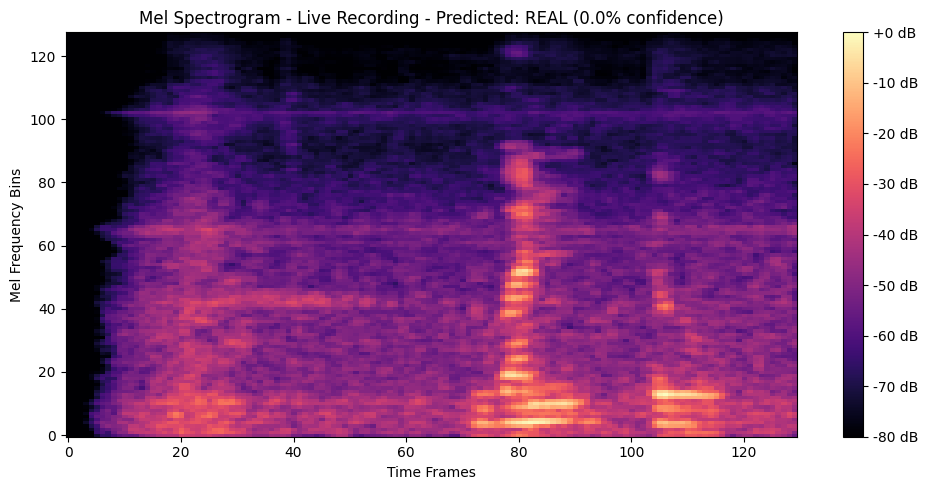

In [12]:
# 1. Install and import dependencies
!pip install soundfile librosa matplotlib

import io
import IPython.display as ipd
import numpy as np
import soundfile as sf
import librosa
import matplotlib.pyplot as plt
from cnn_model import DeepfakeDetectionCNN
import tempfile
import os

# 2. Load your trained model
model = DeepfakeDetectionCNN(input_shape=(128,130,1))
model.load_model('models/deepfake_detection_model.h5')

# 3. Helper to extract mel spectrogram
def audio_to_mel(path, sr=22050, duration=3):
    audio, _ = librosa.load(path, sr=sr, duration=duration)
    if len(audio) < sr*duration:
        audio = np.pad(audio, (0, sr*duration - len(audio)))
    else:
        audio = audio[:sr*duration]
    melspec = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_mels=128, n_fft=2048, hop_length=512
    )
    return librosa.power_to_db(melspec, ref=np.max), audio

# 4. Helper to process audio from numpy array (for live recording)
def audio_array_to_mel(audio_array, sr=22050, duration=3):
    if len(audio_array.shape) > 1:
        audio = np.mean(audio_array, axis=1)
    else:
        audio = audio_array

    if sr != 22050:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=22050)

    target_length = 22050 * duration
    if len(audio) < target_length:
        audio = np.pad(audio, (0, target_length - len(audio)))
    else:
        audio = audio[:target_length]

    melspec = librosa.feature.melspectrogram(
        y=audio, sr=22050, n_mels=128, n_fft=2048, hop_length=512
    )
    return librosa.power_to_db(melspec, ref=np.max), audio

# 5. Decision criteria explanation
def explain_decision(raw_score, confidence):
    print("\n" + "="*60)
    print("DECISION CRITERIA:")
    print("="*60)
    print(f"Raw Model Output (Fake Probability): {raw_score:.4f}")
    print(f"Decision Threshold: 0.5000")
    print(f"Decision Logic: {'FAKE' if raw_score > 0.5 else 'REAL'} (score {'>' if raw_score > 0.5 else '≤'} 0.5)")
    print(f"Final Confidence: {confidence:.1f}%")

    if confidence >= 90:
        reliability = "Very High"
    elif confidence >= 75:
        reliability = "High"
    elif confidence >= 60:
        reliability = "Medium"
    elif confidence >= 50:
        reliability = "Low"
    else:
        reliability = "Very Low"

    print(f"Reliability Level: {reliability}")

    print("\nInterpretation Guidelines:")
    print("• 90-100%: Very confident prediction")
    print("• 75-89%:  High confidence prediction")
    print("• 60-74%:  Medium confidence prediction")
    print("• 50-59%:  Low confidence prediction")
    print("• <50%:    Very uncertain (unreliable)")
    print("="*60)

# 6. Function to analyze audio
def analyze_audio(spec_db, audio, source_name):
    X = spec_db[np.newaxis, ..., np.newaxis]
    pred, raw_fake_score = model.predict_single(spec_db)

    if pred == 'fake':
        confidence_pct = raw_fake_score * 100
    else:
        confidence_pct = (1 - raw_fake_score) * 100

    print(f"\nSource: {source_name}")
    print(f"Prediction: {pred.upper()}")
    print(f"Confidence: {confidence_pct:.1f}%")

    explain_decision(raw_fake_score, confidence_pct)

    plt.figure(figsize=(10,5))
    plt.imshow(spec_db, origin='lower', aspect='auto', cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel Spectrogram - {source_name} - Predicted: {pred.upper()} ({confidence_pct:.1f}% confidence)')
    plt.xlabel('Time Frames')
    plt.ylabel('Mel Frequency Bins')
    plt.tight_layout()
    plt.show()

    return pred, confidence_pct

# 7. Enhanced live recording with start/stop buttons
def record_and_analyze():
    from google.colab import output
    from IPython.display import Javascript, HTML, display
    import base64

    print("🎤 LIVE RECORDING MODE")
    print("Use the Start/Stop buttons to control recording...")

    # Enhanced JavaScript for manual start/stop recording
    RECORD_SCRIPT = """
    <div id="recording-interface">
        <button id="startBtn" onclick="startRecording()"
                style="background:#4CAF50; color:white; padding:15px 25px; font-size:16px; border:none; border-radius:5px; margin:10px;">
            🎤 START RECORDING
        </button>
        <button id="stopBtn" onclick="stopRecording()" disabled
                style="background:#f44336; color:white; padding:15px 25px; font-size:16px; border:none; border-radius:5px; margin:10px;">
            ⏹️ STOP RECORDING
        </button>
        <div id="status" style="margin:10px; font-size:18px; font-weight:bold; color:#333;">
            Ready to record...
        </div>
        <div id="timer" style="margin:10px; font-size:16px; color:#666;"></div>
    </div>

    <script>
    let mediaRecorder;
    let audioChunks = [];
    let stream;
    let recordingTimer;
    let startTime;

    const startBtn = document.getElementById('startBtn');
    const stopBtn = document.getElementById('stopBtn');
    const status = document.getElementById('status');
    const timer = document.getElementById('timer');

    function updateTimer() {
        if (startTime) {
            const elapsed = Math.floor((Date.now() - startTime) / 1000);
            timer.textContent = `Recording time: ${elapsed}s`;
        }
    }

    async function startRecording() {
        try {
            stream = await navigator.mediaDevices.getUserMedia({
                audio: {
                    sampleRate: 22050,
                    channelCount: 1,
                    echoCancellation: true,
                    noiseSuppression: true
                }
            });

            mediaRecorder = new MediaRecorder(stream, {
                mimeType: 'audio/webm;codecs=opus'
            });

            audioChunks = [];
            mediaRecorder.ondataavailable = event => {
                if (event.data.size > 0) {
                    audioChunks.push(event.data);
                }
            };

            mediaRecorder.onstop = async () => {
                const audioBlob = new Blob(audioChunks, { type: 'audio/webm' });
                const reader = new FileReader();
                reader.onloadend = () => {
                    const base64Audio = reader.result;
                    window.recordedAudio = base64Audio;
                };
                reader.readAsDataURL(audioBlob);

                // Stop all tracks
                stream.getTracks().forEach(track => track.stop());

                status.textContent = '✅ Recording completed! Processing...';
                timer.textContent = '';
                startBtn.disabled = false;
                stopBtn.disabled = true;
            };

            mediaRecorder.start();
            startTime = Date.now();
            recordingTimer = setInterval(updateTimer, 1000);

            startBtn.disabled = true;
            stopBtn.disabled = false;
            status.textContent = '🔴 Recording in progress... Click STOP when done';

        } catch (error) {
            status.textContent = '❌ Error: Could not access microphone';
            console.error('Error accessing microphone:', error);
        }
    }

    function stopRecording() {
        if (mediaRecorder && mediaRecorder.state === 'recording') {
            mediaRecorder.stop();
            clearInterval(recordingTimer);
        }
    }

    // Auto-stop after 30 seconds maximum
    function autoStop() {
        if (mediaRecorder && mediaRecorder.state === 'recording') {
            stopRecording();
            status.textContent = '⏰ Auto-stopped after 30 seconds';
        }
    }
    </script>
    """

    # Display the recording interface
    display(HTML(RECORD_SCRIPT))

    # Wait for recording to be completed
    print("\n⏳ Waiting for recording...")
    print("Click START RECORDING, speak, then click STOP RECORDING")

    # Check for recorded audio
    import time
    while True:
        try:
            # Check if recording is available
            recorded_data = output.eval_js('window.recordedAudio')
            if recorded_data:
                break
            time.sleep(1)
        except:
            time.sleep(1)

    print("🎵 Processing recorded audio...")

    # Process the recorded audio
    try:
        # Extract base64 audio data
        audio_data = recorded_data.split(',')[1]
        audio_bytes = base64.b64decode(audio_data)

        # Save temporarily
        with tempfile.NamedTemporaryFile(suffix='.webm', delete=False) as tmp_file:
            tmp_file.write(audio_bytes)
            tmp_path = tmp_file.name

        # Convert to wav and load
        wav_path = tmp_path.replace('.webm', '.wav')
        os.system(f'ffmpeg -i {tmp_path} -ar 22050 -ac 1 {wav_path} -y -loglevel quiet')

        # Load and analyze
        data, sr = sf.read(wav_path)

        print("🔊 Recorded audio playback:")
        display(ipd.Audio(data, rate=sr))

        # Process and analyze
        spec_db, audio = audio_array_to_mel(data, sr, duration=3)
        analyze_audio(spec_db, audio, "Live Recording")

    except Exception as e:
        print(f"❌ Error processing recording: {e}")
        print("Note: Make sure you have ffmpeg installed for audio conversion")

    finally:
        # Clean up temporary files
        try:
            if 'tmp_path' in locals() and os.path.exists(tmp_path):
                os.remove(tmp_path)
            if 'wav_path' in locals() and os.path.exists(wav_path):
                os.remove(wav_path)
        except:
            pass

# 8. Main interface
print("🎵 DEEPFAKE AUDIO DETECTION SYSTEM")
print("="*50)
print("Choose an option:")
print("1. Upload audio file")
print("2. Live recording (manual start/stop)")
print("="*50)

mode = input("Enter choice (1 or 2): ").strip()

if mode == "1":
    # File upload mode
    from google.colab import files
    print("\n📁 FILE UPLOAD MODE")
    uploaded = files.upload()

    for fname in uploaded:
        print(f"Loaded file: {fname}")
        data, sr = sf.read(io.BytesIO(uploaded[fname]))
        display(ipd.Audio(data, rate=sr))

        spec_db, audio = audio_to_mel(fname)
        analyze_audio(spec_db, audio, fname)

elif mode == "2":
    # Live recording mode with manual controls
    record_and_analyze()

else:
    print("Invalid choice. Please run again and select 1 or 2.")
